# KNN and Naive Bayes

## Section 1 - kNN 

In [59]:
# These are the libraries you will use for this assignment, you may not import anything else
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import calendar
from tqdm import tqdm
%matplotlib inline

# Starting off loading a training set
df_melb = pd.read_csv('melb_data_train.csv')

## Q1.1 - Fix a column of data to be numeric
If we inspect our dataframe, `df_melb` using the `dtypes` method, we see that the column "Date" is an object.  However, we think this column might contain useful information so we want to convert it to [seconds since epoch](https://en.wikipedia.org/wiki/Unix_time). Use only the existing imported libraries to create a new column "unixtime". Be careful, the date strings in the file have some non-uniform formatting that you have to fix first.  Print out the min and max epoch time to check your work.  Drop the original "Date" column. The [documentation](https://docs.python.org/3/library/time.html) for the Python 3 time will be really useful. 

In [60]:
def epoch (df_melb):
    df_melb['temp'] = pd.to_datetime(df_melb['Date'])
    df_melb['unixtime'] = (df_melb['temp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    df_melb.drop(columns = ['Date', 'temp'], inplace = True)
    print("Min: " + str(df_melb['unixtime'].min()))
    print("Max: " + str(df_melb['unixtime'].max()))
    return df_melb

df_melb = epoch(df_melb)

Min: 1457481600
Max: 1512691200


## Q1.2 Use Imputation to fill in missing values
kNN doesn't work when all of the attributes are not valid for all of the attribute columns, so fill in all the missing values in `df_melb` with the mean of that column.  Save the mean of each column in a dictionary, `dict_imputation`, whose key is the column name, so we can apply the same imputation to the test set later. Show your `dict_imputation` dictionary and the head of your `df_melb` dataframe

In [61]:
def imputation(df_melb):
    #cars, building area, yearbuilt contain missing values.
    dict_imputation = {'Car': df_melb['Car'].mean(skipna = True), 
                       'BuildingArea' : df_melb['BuildingArea'].mean(skipna = True),
                    'YearBuilt' : df_melb['YearBuilt'].mean(skipna = True)}

    df_melb['Car'].fillna(dict_imputation['Car'], inplace = True)
    df_melb['BuildingArea'].fillna(dict_imputation['BuildingArea'], inplace = True)
    df_melb['YearBuilt'].fillna(dict_imputation['YearBuilt'], inplace = True)
    return dict_imputation, df_melb

In [62]:
# Print out dict_imputation
dict_imputation, df_melb = imputation(df_melb)
dict_imputation

{'Car': 1.4938398357289528,
 'BuildingArea': 131.379476861167,
 'YearBuilt': 1971.0204429301534}

## Q1.3 Normalize all the attributes to be between [0,1]
Normalize all the attribute columns in `df_melb` so they have a value between zero and one (inclusive). Save the (min,max) tuple used to normalize to a dictionary, `dict_normalize`, so we can apply it to the test set later.  The dataframe `df_melb` is now your "model" that you can use to classify new data points.

In [63]:
types = df_melb['Type'].copy()
df_melb.drop(columns = ['Type'], inplace = True)

In [64]:
# method to normalize, optionally using a dict.
def normalize(df_melb, useDict = None):
    dict_normalize = {}
    for (colN, col) in df_melb.iteritems():  
        if useDict == None:
            dict_normalize[colN] = (col.min(), col.max())
            df_melb[colN] = (df_melb[colN] -  dict_normalize[colN][0])/(dict_normalize[colN][1] - dict_normalize[colN][0])
        else:
            df_melb[colN] = (df_melb[colN] -  useDict[colN][0])/(useDict[colN][1] - useDict[colN][0])
    return dict_normalize, df_melb

In [65]:
# print out dict_normalize
dict_normalize, df_melb = normalize(df_melb, None)
dict_normalize

{'Rooms': (1, 7),
 'Price': (210000, 5020000),
 'Distance': (0.7, 47.3),
 'Postcode': (3000, 3810),
 'Bathroom': (0, 5),
 'Car': (0.0, 8.0),
 'Landsize': (0, 41400),
 'BuildingArea': (0.0, 3558.0),
 'YearBuilt': (1850.0, 2016.0),
 'unixtime': (1457481600, 1512691200)}

## Q1.4 Load in the Test data and prep it for classification
Everything we did to our "train" set, we need to now do in our "test" set. 

In [66]:
df_test = pd.read_csv("melb_data_test.csv")

In [67]:
# Add unixtime and column remove 'Date' string column
df_test = epoch(df_test)
df_test.head(10)

Min: 1457481600
Max: 1512691200


,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,2,t,790000,11.2,3046,2,1.0,208,127.0,2010.0,1497657600
1,3,h,1355000,8.8,3072,1,2.0,916,NaN,NaN,1476489600
2,5,h,2810000,6.3,3143,2,2.0,617,NaN,NaN,1472342400
3,3,h,850000,10.5,3034,1,1.0,593,118.0,1970.0,1457481600
4,3,h,810000,38.0,3199,1,2.0,835,118.0,1960.0,1502064000
5,3,t,1015000,3.5,3068,2,1.0,112,145.0,2000.0,1470787200
6,3,t,881000,13.4,3130,1,1.0,300,NaN,NaN,1503100800
7,4,h,1975000,6.4,3078,2,2.0,600,NaN,NaN,1495238400
8,2,h,417000,13.0,3046,1,1.0,172,77.0,2013.0,1480204800
9,3,h,705000,15.5,3038,2,1.0,677,138.0,1980.0,1489017600


In [68]:
# Imputation - must use dictionary from above!  
df_test['Car'].fillna(dict_imputation['Car'], inplace = True)
df_test['BuildingArea'].fillna(dict_imputation['BuildingArea'], inplace = True)
df_test['YearBuilt'].fillna(dict_imputation['YearBuilt'], inplace = True)

df_test.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,2,t,790000,11.2,3046,2,1.0,208,127.000000,2010.000000,1497657600
1,3,h,1355000,8.8,3072,1,2.0,916,131.379477,1971.020443,1476489600
2,5,h,2810000,6.3,3143,2,2.0,617,131.379477,1971.020443,1472342400
3,3,h,850000,10.5,3034,1,1.0,593,118.000000,1970.000000,1457481600
4,3,h,810000,38.0,3199,1,2.0,835,118.000000,1960.000000,1502064000


In [69]:
# get the test types
ttypes = df_test['Type'].copy()
df_test.drop(columns = ['Type'], inplace = True)

In [70]:
# Scale - must use dictionary from above!
_, df_test = normalize(df_test, dict_normalize)
df_test.head()

,Rooms,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.166667,0.120582,0.225322,0.056790,0.4,0.125,0.005024,0.035694,0.963855,0.727700
1,0.333333,0.238046,0.173820,0.088889,0.2,0.250,0.022126,0.036925,0.729039,0.344288
2,0.666667,0.540541,0.120172,0.176543,0.4,0.250,0.014903,0.036925,0.729039,0.269171
3,0.333333,0.133056,0.210300,0.041975,0.2,0.125,0.014324,0.033165,0.722892,0.000000
4,0.333333,0.124740,0.800429,0.245679,0.2,0.250,0.020169,0.033165,0.662651,0.807512


## Q1.5 Write the kNN classifier function
Your function `knn_class`, should take four parameters, the training dataframe, the hyper parameter `k`, the name of the target column, and a single observation row (a series generated from iterrows) of the test dataframe.  It should return a single target classification. To find the distance between the single observation and the training data frame you may use the [L2 norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)

In [71]:
def knn_class(df_train, k, target_col, observation ):
    distances = None
    distances = pd.DataFrame(columns = ['Distances', 'Index']) 
    index = 0;
    for row in df_train.iterrows():
        newrow = {'Distances' : np.linalg.norm(row[1] - observation), 'Index' : row[0]}
        distances = distances.append(newrow, ignore_index = True)
    
    # sort, select k closest, returns most voted
    distances.sort_values(by = ['Distances'], inplace = True)
    cn = target_col.iloc[distances.head(k)['Index']]
    return cn.value_counts().idxmax()

knn_class(df_melb, 25, types, df_test.loc[0])

't'

## Q1.6 Compute the accuracy using different k values
For each value of $k$ in the set $\{1,3,13,25,50,100\}$ calculate the class prediction for each observation in the test set, and the overall accuracy of the classifier.  Plot the accuracy as a function of $k$.

Please note: this can be slow, and took the 13" Macbook I used about 5 mins to complete.  When testing your code, you might want to use a smaller test/train data set until you are sure your code is working, and then run this cell using the entire dataframe/series.  

In [72]:
poss_k = [1,3,13,25,50,100]

In [78]:
accuracy = []

# calculate accuracy for eack k
for k in poss_k:
    results = []
    
    # create numpy array of predictions, then count matches between truth.
    for idx, rows in tqdm(df_test.iterrows(), total = df_test.shape[0]):
        results.append(knn_class(df_melb, k, types, rows))
    accuracy.append(np.count_nonzero(ttypes.to_numpy() == np.asarray(results)) / len(results))



100%|██████████| 122/122 [02:33<00:00,  1.26s/it]


## Section 2 - Naive Bayes 

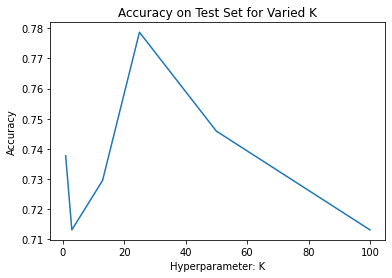

In [88]:
plt.plot(poss_k, a)
plt.xlabel("Hyperparameter: K")
plt.ylabel("Accuracy")
plt.title("Accuracy on Test Set for Varied K")
plt.show()

### Q2.1 Theoretical exercise on Probability Review - Joint Probability of dependent events
In my neighborhood in Austin, I took a survey and found that 42% of the houses have at least one dog, and 25% of the houses that own a dog also own a cat.  In addition, I found that 31% of families own a cat.

Answer the following by typing out your answers below using markdown cells.  Define all of your terms and show your work. When you define your terms you should write out the meaning of each variable. (Note markdown supports LaTex so, you can make fractions like this: `$\frac{a}{b}$` = $\frac{a}{b}$)

### Q2.1a
the probability that a randomly selected house in my neighborhood owns a cat and a dog

$$P(OwnsDog) = 0.42$$
$$P(OwnsCat | OwnsDog) = 0.25$$
$$P(OwnsCat) = 0.31$$ \
\
$$P(Dog\space and \space Cat) = P(OwnsDog)*P(OwnsCat | OwnsDog)$$
$$ = 0.42 * 0.25 = 0.105 $$

### Q2.1b
the conditional probability that a randomly selected family owns a dog given that it owns a cat? 

$$P(Owns Dog | Owns Cat)$$ = $\frac{P(Owns Cat | Owns Dog)*P(Owns Dog)}{P(Owns Cat)}$ = $\frac{0.25 * 0.42}{0.31} = 0.34$

### Q2.2 Theoretical exercise on Probability Review - Marginals and  Bayes Theorem 
In Austin, 45% of registered voters are Democrats, 37% of registered voters are Republicans, and the remaining 18% are Independents. In the last election 35% of the Democrats, 62% of the Republications, and 58% of the Independents voted. A voter is chosen at random.  

Answer the following by typing out your answers below using markdown cells.  Define all of your terms and show your work. When you define your terms you should write out the meaning of each variable. (Note markdown supports LaTex so, you can make fractions like this: `$\frac{a}{b}$` = $\frac{a}{b}$)

### Q2.2a
What fraction of registered voters voted in the election? 

$$P(Voted|Demo) + P(Voted|Repub) + P(Voted|Indep) $$
$$(0.45 * 0.35) + (0.37 * 0.67) + (0.18 * 0.58) = 0.5098$$

### Q2.2b
What is the probability that someone who voted is a Republican? 

$ P(Repub | Voted) = \frac{P(Voted | Repub)*P(Repub)}{P(Voted)} = \frac{0.62*0.37}{0.5098} = 0.45$

## Q2.3 Loading in the housing data and calculating the prior probabilities
Let us load in the train set again fresh, since Naive Bays and kNN have much different requirements. Load the prior probabilities for each possible 'Type' in a dictionary, `dict_priors`, where the key is the possible 'Type' values and the value is the prior probabilities. Show the dictionary.

In [101]:
# reload train
df_melb = pd.read_csv('melb_data_train.csv')

In [102]:
dict_priors = (df_melb['Type'].value_counts() / df_melb.shape[0]).to_dict()

In [103]:
# Show the dictionary
dict_priors

{'h': 0.4512820512820513, 'u': 0.4, 't': 0.14871794871794872}

## Q2.4 Create a model for the distribution of all of the continuous attributes
First, let us just drop the 'Date' column.  Now, for each class, and for each attribute calculate the sample mean and sample standard deviation.  You should store the model in a nested dictionary, `dict_nb_model`, such that `dict_nb_model['h']['Rooms']` is a tuple containing the mean and standard deviation for the target Type 'h' and the attribute 'Rooms'.  Show the model for target type 'u'.   

In [104]:
# drop dates, and NaNs
df_melb.drop(columns=["Date"], inplace=True)
df_melb.dropna(inplace=True)

c_types = ['h', 't', 'u']
dict_nb_model = {}
for c_t in c_types:
    df_temp = df_melb.loc[df_melb['Type'] == c_t]
    t_dict = {}
    for (colN, col) in df_temp.iteritems():
        if (colN != 'Type'):
            t = (col.mean(), col.std())
            t_dict.update({colN: t})
    dict_nb_model.update({c_t : t_dict})

In [105]:
# Show the model for target type 'u'
dict_nb_model['u']

{'Rooms': (2.01025641025641, 0.5919541601588044),
 'Price': (616878.4615384615, 205784.81541492048),
 'Distance': (8.679487179487179, 5.005418686833789),
 'Postcode': (3115.9692307692308, 59.656742145593675),
 'Bathroom': (1.1897435897435897, 0.40600827260049394),
 'Car': (1.1435897435897435, 0.6091209111747407),
 'Landsize': (296.8820512820513, 587.751123285703),
 'BuildingArea': (85.29435897435899, 42.916531539198374),
 'YearBuilt': (1975.8564102564103, 25.056017600072682)}

## Q2.5 Write a function that calculates the probability of a Gaussian
Given the mean ($\mu$), standard deviation ($\sigma$), and a observed point, `x`, return the probability.  
Use the formula $p(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$ ([wiki](https://en.wikipedia.org/wiki/Normal_distribution)).  You should use [numpy's exp](https://numpy.org/doc/stable/reference/generated/numpy.exp.html) function in your solution. 

In [106]:
def get_p( mu, sigma, x):
    r = (-0.5) * np.square((x - mu) / sigma)
    r = np.exp(r)
    r *= 1 / (sigma * np.sqrt(2 * np.pi))
    return r

## Q2.6 Write the Naive Bayes classifier function
The Naive Bayes classifier function, `nb_class`, should take as a parameter the prior probability dictionary. `dict_priors`, the dictionary containing all of the gaussian distribution information for each attribute, `dict_nb_model`, and a single observation row (a series generated from iterrows) of the test dataframe. It should return a single target classification. For this problem, all of our attributes are represented as Gaussians, so we don't worry about categorical data. Make sure to skip attributes that do not have a value in the observation. 

In [111]:
def nb_class( dict_priors, dict_nb_model, observation):  
    class_con_p = {}
    # for each class type (h,t,u)
    for class_t in dict_priors.keys():
        gauss_prod = 1
        # calculate the gaussian product
        for colN in dict_nb_model[class_t].keys():
            t = dict_nb_model[class_t][colN]
            gauss_prod *= get_p(t[0], t[1], observation[colN])
        
        # store product with priors
        class_con_p.update({class_t: gauss_prod * dict_priors[class_t]})
        
    return max(class_con_p, key=class_con_p.get)

## Q2.7 Calculate the accuracy using Naive Bayes classifier function on the test set
Load the test set from file, classify each row using your `nb_class`, and then show the accuracy. 

In [108]:
df_test = pd.read_csv('melb_data_test.csv')
df_test.dropna(inplace=True)
ttypes = df_test['Type']
df_test.drop(columns=['Type'], inplace=True)

In [109]:
# calculate the test accuracy
results = []
for idx, rows in tqdm(df_test.iterrows(), total = df_test.shape[0]):
    results.append(nb_class(dict_priors, dict_nb_model,rows))
acc_test = np.count_nonzero(ttypes.to_numpy() == np.asarray(results)) / len(results)


# create the training set again (for safety)
types = df_melb['Type']
df_melb.drop(columns=['Type'], inplace=True)

# calculate the training accuracy
results = []
for idx, rows in tqdm(df_melb.iterrows(), total = df_melb.shape[0]):
    results.append(nb_class(dict_priors, dict_nb_model,rows))
acc_train  = np.count_nonzero(types.to_numpy() == np.asarray(results)) / len(results)



100%|██████████| 479/479 [00:00<00:00, 2429.55it/s]


In [110]:
# Show the accuracy 
print("Train: " + str(acc_train))
print("Test: " + str(acc_test))

Train: 0.7766179540709812
Test: 0.6730769230769231
